# Data processing
### Flood fraction
Process flood map vector files for each region. Flood maps obtained from [Copernicus EMS](https://emergency.copernicus.eu/mapping/list-of-activations-rapid). Steps to add new regions:
1. Download vector flood maps from [Copernicus EMS](https://emergency.copernicus.eu/mapping/list-of-activations-rapid)
2. Manually define subregions corresponding to those displayed on EMS using geojson.io
3. Add the geoJSON feature collection to event_geojsons.csv
4. Add the storm start and dissipation dates to event_dates.csv
5. Download IBTrACs data (note Agency period)
#### Left to do:
- [ ] Add wind field data
- [ ] Better merging of topography and bathymetry data

In [81]:
from os.path import join
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [242]:
# load general storm/aoi data
storm = "gombe"
region = "mossuril"
subregion = 1

wd = join("..", "data", "indata_new")
indir = join(wd, f"{storm}_{region}")
startdate, enddate = [*pd.read_csv(join(wd, "event_dates.csv"),
                                   index_col="storm").loc[storm]]

from shapely.geometry import shape
from ast import literal_eval

geoJSON = literal_eval(pd.read_csv(join(wd, "event_geojsons.csv"),
                                   index_col="region").loc[region][0])

polys = [shape(x['geometry']) for x in geoJSON['features']]
aoi = gpd.GeoDataFrame({"geometry": polys[subregion]}, index=[0])
aoi = aoi.set_crs("EPSG:4326")

from data_utils import *
aoi_pm = aoi.to_crs("EPSG:3857").geometry[0]  # Pseudo-Mercator

grid_pm = make_grid(*aoi_pm.bounds)
grid_lonlat = grid_pm.to_crs("EPSG:4326")

## Flood fraction

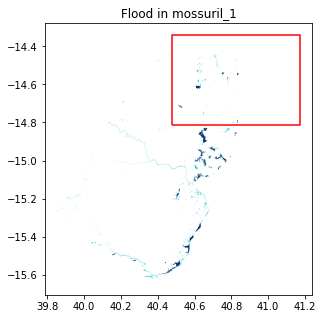

In [243]:
region_boundary = gpd.read_file(join(indir, "areaOfInterest.shp"))
flood = gpd.read_file(join(indir, "flood.shp"))
pwater = gpd.read_file(join(indir, "hydrographyA.shp"))
trueflood = gpd.overlay(flood, pwater, how="difference")

# plot flood data
fig, ax = plt.subplots(1, figsize=(10, 5))
trueflood.plot(ax=ax, color="#21c4c5")
pwater.plot(ax=ax, color="#01306e")
aoi.boundary.plot(color="red", ax=ax)
ax.set_title(f"Flood in {region}_{subregion}");

<AxesSubplot:>

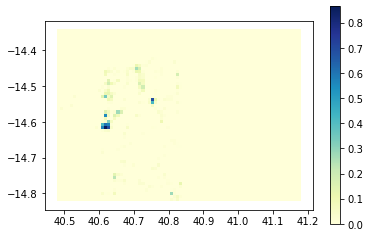

In [244]:
# load the feature_stats shapefile or else create one
try:
    feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}.shp'))
except:
    feature_gdf = grid_lonlat

# avoid recalculating floodfrac
if "floodfrac" not in feature_gdf:
    # calculate flood fraction over the grid cells in Pseudo-Mercator
    flood_pm = flood.to_crs("EPSG:3857")    
    floodfrac_gdf = get_grid_intersects(flood_pm, grid_pm)

    # save the feature_stats shapefile with flood fraction
    feature_gdf["floodfrac"] = floodfrac_gdf["floodfrac"]
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}.shp'))
    
feature_gdf.plot(column="floodfrac", cmap="YlGnBu", legend=True)

## GEE datasets
Load each data set, check if it's already in the feature_gdf and if not, calculate it.

In [245]:
import folium
import ee

# workaround to solve conflict with collections
import collections
collections.Callable = collections.abc.Callable

try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()


# Add EE drawing method to folium.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True):
    """Method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True,
    show = show
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

aoi_ee = ee.Geometry.Polygon(aoi.geometry[0].__geo_interface__["coordinates"],
                             proj=ee.Projection('EPSG:4326'))
location = aoi_ee.centroid().coordinates().getInfo()[::-1]

In [246]:
# convert grid to a GEE Feature Collection
features = []
for geom in grid_lonlat.geometry:
    poly = ee.Geometry.Polygon(geom.__geo_interface__['coordinates'],
                        proj=ee.Projection('EPSG:4326'))
    features.append(poly)

grid_ee = ee.FeatureCollection(features)
print(f"Grid size: {grid_ee.size().getInfo()}")

Grid size: 4290


### Start importing GEE datasets

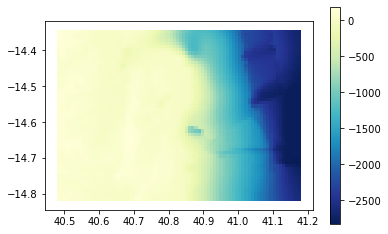

In [247]:
# gebco bathymetry data
# Resolution is 15 arcseconds (approx. 0.5km).
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}.shp'))

if "gebco" not in feature_gdf:
    gebco = ee.Image(ee.ImageCollection("projects/sat-io/open-datasets/gebco/gebco_grid")
                      .filterBounds(aoi_ee)
                      .select("b1")
                      .median()).clip(aoi_ee)
    # gebco = gebco.unmask(0)  # set null values to zero
    gebco.projection().getInfo()

    # Add reducer output to the Features in the collection.
    scale = gebco.projection().nominalScale().getInfo()
    mean_gebco = gebco.reduceRegions(collection=grid_ee,
                                             reducer=ee.Reducer.mean(),
                                              scale=10)

    # print(f"Size: {mean_gebco.size().getInfo()}")
    gebco_list = mean_gebco.aggregate_array('mean').getInfo()
    # print(len(gebco_list))

    feature_gdf["gebco"] = gebco_list
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}.shp'))
    
feature_gdf.plot(column='gebco', cmap="YlGnBu_r", legend=True);

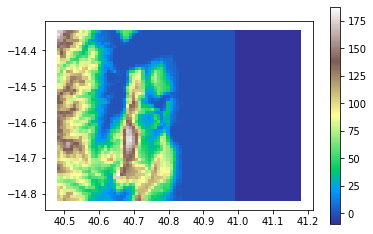

In [248]:
# FABDEM DTM (from awesome-gee-community-datasets)
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}.shp'))

if "fabdem" not in feature_gdf:
    # https://code.earthengine.google.com/2e4110a0e6769825650a1b98ec4cf38e
    elev = ee.Image(ee.ImageCollection("projects/sat-io/open-datasets/FABDEM")
        .filterBounds(aoi_ee)
        .mosaic()
        .setDefaultProjection('EPSG:4326', scale=10)  # EPSG:3857
        .clip(aoi_ee))
    
    elev = elev.unmask(-999)  # set null values to zero

    # Add reducer output to the Features in the collection.
    mean_elev = elev.reduceRegions(collection=grid_ee,
                                             reducer=ee.Reducer.mean(),
                                              scale=10)

    # print(f"Size: {mean_soilcarbon.size().getInfo()}")
    elev_list = mean_elev.aggregate_array('mean').getInfo()
    # print(len(soilcarbon_list))

    feature_gdf["fabdem"] = elev_list
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}.shp'))
    
feature_gdf.plot(column='fabdem', cmap="terrain", legend=True, vmin=-10);           

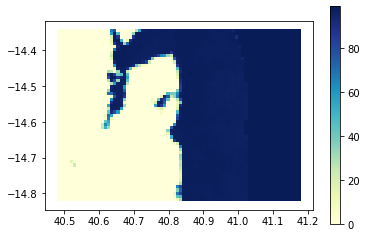

In [249]:
# jrc_permwater
# Resolution is 30 arcseconds (approx. 1km).
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}.shp'))

if "jrc_permwa" not in feature_gdf:
    print("Recalculating permanent water...")
    jrc_permwater = (ee.Image("JRC/GSW1_3/GlobalSurfaceWater")
                     .clip(aoi_ee)
                     .select("occurrence"))
    jrc_permwater = jrc_permwater.unmask(0)  # set null values to zero
    jrc_permwater.projection().getInfo()

    # Add reducer output to the Features in the collection.
    scale = jrc_permwater.projection().nominalScale().getInfo()
    mean_jrc_permwater = jrc_permwater.reduceRegions(collection=grid_ee,
                                             reducer=ee.Reducer.mean(),
                                              scale=scale)

    # print(f"Size: {mean_jrc_permwater.size().getInfo()}")
    jrc_permwater_list = mean_jrc_permwater.aggregate_array('mean').getInfo()
    # print(len(jrc_permwater_list))

    feature_gdf["jrc_permwa"] = jrc_permwater_list
    
    # slightly hacky way of filling-in ocean
    max_pw = feature_gdf.jrc_permwa.describe()["max"]
    pw_ix = feature_gdf[(feature_gdf['jrc_permwa']<=90) & (feature_gdf["gebco"]<-100)].index
    feature_gdf.loc[pw_ix, "jrc_permwa"] = 100
    
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}.shp'))

feature_gdf.plot(column='jrc_permwa', cmap="YlGnBu", legend=True);

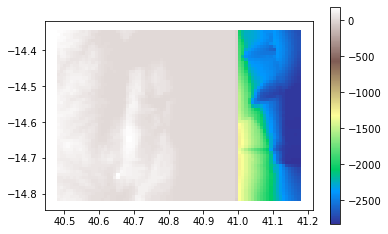

In [250]:
# now to calculate a merged elevation column
# TODO: do this better
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}.shp'))

if "elevation" not in feature_gdf:
    # calculate the average difference between elevations on land
    land = feature_gdf[feature_gdf['jrc_permwa'] <= 50]
    land_diff = land['fabdem'] - land['gebco']
    diff = land_diff.mean()
    feature_gdf['gebco'] = feature_gdf['gebco'].apply(lambda x: x + diff)
    feature_gdf['elevation'] = feature_gdf['fabdem']
    feature_gdf.loc[feature_gdf['elevation'] == -999, "elevation"] = feature_gdf.loc[feature_gdf['elevation'] == -999, "gebco"]
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}.shp'))


feature_gdf.plot(column='elevation', cmap="terrain", legend=True); 

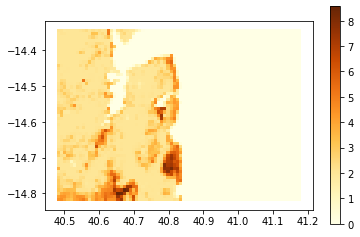

In [251]:
# soil organic carbon
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}.shp'))

if "soilcarbon" not in feature_gdf:
    soilcarbon = (ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02")
                  .select('b0')
                  .clip(aoi_ee))
    soilcarbon = soilcarbon.unmask(0)  # set null values to zero
    soilcarbon.projection().getInfo()

    # Add reducer output to the Features in the collection.
    scale = soilcarbon.projection().nominalScale().getInfo()
    mean_soilcarbon = soilcarbon.reduceRegions(collection=grid_ee,
                                             reducer=ee.Reducer.mean(),
                                              scale=scale)

    # print(f"Size: {mean_soilcarbon.size().getInfo()}")
    soilcarbon_list = mean_soilcarbon.aggregate_array('mean').getInfo()
    # print(len(soilcarbon_list))

    feature_gdf["soilcarbon"] = soilcarbon_list
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}.shp'))
    
feature_gdf.plot(column='soilcarbon', cmap="YlOrBr", legend=True);

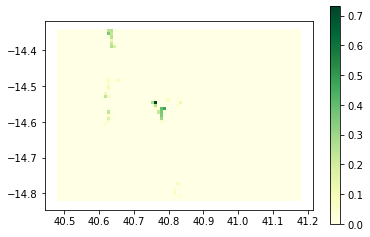

In [252]:
# mangrove forests from year 2000 Giri (2011)
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}.shp'))

if "mangrove" not in feature_gdf:
    mangrove = ee.Image(ee.ImageCollection("LANDSAT/MANGROVE_FORESTS")
                               .filterBounds(aoi_ee)
                               .first()
                               .clip(aoi_ee))
    mangrove = mangrove.unmask(0)  # set null values to zero
    mangrove.projection().getInfo()

    # Add reducer output to the Features in the collection.
    scale = mangrove.projection().nominalScale().getInfo()
    mean_mangrove = mangrove.reduceRegions(collection=grid_ee,
                                             reducer=ee.Reducer.mean(),
                                              scale=scale)

    # print(f"Size: {mean_mangrove.size().getInfo()}")
    mangrove_list = mean_mangrove.aggregate_array('mean').getInfo()
    # print(len(mangrove_list))

    feature_gdf["mangrove"] = mangrove_list
    feature_gdf.to_file(join(indir, f'feature_stats_{subregion}.shp'))
    
feature_gdf.plot(column='mangrove', cmap="YlGn", legend=True);

/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


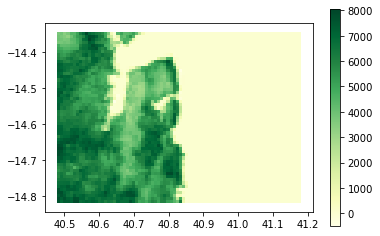

In [253]:
# NDVI (reprojected and masked from mangroves)
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}.shp'))

if "ndvi" not in feature_gdf:
    print("Recalculating ndvi...")
    
    # mangrove
    mangrove = ee.Image(ee.ImageCollection("LANDSAT/MANGROVE_FORESTS")
                                   .filterBounds(aoi_ee)
                                   .first()
                                   .clip(aoi_ee))

    # NDVI
    ndvi = ee.Image(ee.ImageCollection("MODIS/006/MOD13Q1")
                    .filterBounds(aoi_ee)
                    .filterDate(ee.Date(startdate).advance(-2, 'month'), ee.Date(enddate))
                    .mean()
                    .clip(aoi_ee))
                    #.reproject('SR-ORG:6974', scale=10))

    ndvi = ndvi.select('NDVI')
    # ndvi.projection().getInfo()                 # EPSG:4326
    # ndvi.projection().nominalScale().getInfo()  # 111319.49079327357

    # mask out mangroves
    print("Masking out mangrove presence...")
    mangrove = mangrove.unmask(0)
    mangrove_mask = mangrove.eq(0)
    ndvi_masked = ndvi.updateMask(mangrove_mask)
    ndvi = ndvi_masked.unmask(0)

    mean_ndvi = ndvi.reduceRegions(collection=grid_ee,
                                   reducer=ee.Reducer.mean(),
                                   scale=10)

    ndvi_list = mean_ndvi.aggregate_array('mean').getInfo()

    feature_gdf["ndvi"] = ndvi_list


feature_gdf.to_file(join(indir, f'feature_stats_{subregion}.shp'))
feature_gdf.plot(column='ndvi', cmap="YlGn", legend=True);

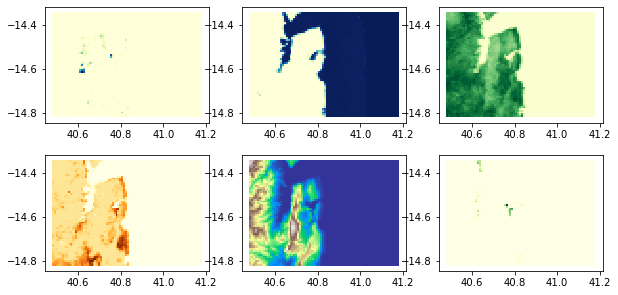

In [254]:
fig, ax = plt.subplots(2,3, figsize=(10, 5))

feature_gdf.plot(column="floodfrac", ax=ax[0, 0], cmap="YlGnBu")
feature_gdf.plot(column="jrc_permwa", ax=ax[0, 1], cmap="YlGnBu")
feature_gdf.plot(column="ndvi", ax=ax[0, 2], cmap="YlGn")
feature_gdf.plot(column="soilcarbon", ax=ax[1, 0], cmap="YlOrBr")
feature_gdf.plot(column="elevation", ax=ax[1, 1], cmap="terrain", vmin=0)
feature_gdf.plot(column="mangrove", ax=ax[1, 2], cmap="YlGn");

In [255]:
# save all progress to dir of dfs
feature_gdf = gpd.read_file(join(indir, f'feature_stats_{subregion}.shp'))
print("Current features:", *feature_gdf.columns)
feature_gdf.to_file(join(wd, "feature_stats", f"{storm}_{region}_{subregion}.shp"))

Current features: floodfrac soilcarbon mangrove gebco jrc_permwa ndvi fabdem elevation geometry


/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
